# Numpyro version

This is about 100x faster! and the code is nicer! joy oh joy!

# The Bayesian Sampler model is roughly:

$$P_{BS}(A) \sim Beta(\beta + S(A), \beta+F(A))$$

Where $S(A)$ and $F(A)$ are the number of success and failures sampled.

We can rewrite that:

$$P_{BS}(A) \sim Beta(\beta + \pi(A)N, \beta+(1-\pi(A))N)$$


Where $\pi(A)$ is the proportion of successes in the mental simulation with $N$ samples and is a function of the true underlying model probability, $p(A)$. It is distributed:

$$\pi(A) \sim Beta(p(A)*N, (1-p(A))*N)$$

To which we assign a uniform prior (or the multidimensional dirichlet equivalent):

$$p(A) \sim Beta(1,1)$$

This notebook will be dedicated to estimating parameters within some __simulated data__.

In [1]:
%config IPCompleter.use_jedi = False
import numpyro

numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS

# import pyro.infer
# import pyro.optim
# import pyro.distributions as dist
# from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
import functools

from dfply import *

## Simulate data

## create and fit model

k is relatively independent of both Beta and k though, so that's good.

In [19]:
# removed torch dependency 3/22/21, 12:22 PM
%run -i 'model_helpers.py'

trial_types = [
    'A',
    'AandB',
    'AandnotB',
    'AgB',
    'AgnotB',
    'AorB',
    'AornotB',
    'B',
    'BgA',
    'BgnotA',
    'notA',
    'notAandB',
    'notAandnotB',
    'notAgB',
    'notAgnotB',
    'notAorB',
    'notAornotB',
    'notB',
    'notBgA',
    'notBgnotA'
    ]

## ------
## simulate data into pandas DataFrame
## -------
n_participants = 20
n_blocks = 2
n_trial_types = len(trial_types)

trials = trial_types*n_blocks
conds = np.tile(np.array([0,1]).repeat(len(trial_types)), n_participants)
blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))

all_thetas = make_thetas(n_participants)
# all_responses = create_response_vec_complex(trials, all_thetas, beta = 1, N_base = 15, N_prime = 2, k = 20) # updated for Normal errors, .05 is a pretty large amount of noise

all_trials = trials*n_participants
all_blocks = blocks*n_participants

params = {
    "N_base": {k:1 + np.random.normal(1,.1) for k in range(0,n_participants)},
    "N_delta": {k:1 + np.random.normal(15,2) for k in range(0,n_participants)},
    "beta": {k:np.random.uniform() for k in range(0, n_participants)}
}



sim_data = pd.DataFrame(
    data = {
        "ID": all_participants,
        "querytype": all_trials, 
        "block": all_blocks,
#         "estimate": all_responses,
        "coldrainy": conds
    }) >> mutate(
        conjdisj_trial = X.querytype.apply(is_conjdisj),
        N_base = X.ID.apply(lambda x: params["N_base"][x]),
        N_delta = X.ID.apply(lambda x: params["N_delta"][x]),
        beta = X.ID.apply(lambda x: params["beta"][x]),
    theta = X.ID.apply(lambda x: all_thetas[x])
    ) >> mutate(N = X.N_base + X.N_delta * abs(1-X.conjdisj_trial))

sim_data["prob"] = sim_data.apply(lambda x: calc_prob(x.querytype, x.theta), axis=1)
sim_data["estimate"] = sim_data.apply(lambda x: sim_sampling(x.prob, x.beta, x.N, 25), axis=1)
sim_data[sim_data.ID==1]

,ID,querytype,block,coldrainy,conjdisj_trial,N_base,N_delta,beta,theta,N,prob,estimate
40,1,A,0,0,0,1.931033,17.503886,0.332329,"[0.2436231425468963, 0.4436482671093577, 0.190...",19.434919,0.6872714,0.772035
41,1,AandB,0,0,1,1.931033,17.503886,0.332329,"[0.2436231425468963, 0.4436482671093577, 0.190...",1.931033,0.24362314,0.267640
42,1,AandnotB,0,0,1,1.931033,17.503886,0.332329,"[0.2436231425468963, 0.4436482671093577, 0.190...",1.931033,0.44364828,0.459487
43,1,AgB,0,0,0,1.931033,17.503886,0.332329,"[0.2436231425468963, 0.4436482671093577, 0.190...",19.434919,0.56144476,0.475502
44,1,AgnotB,0,0,0,1.931033,17.503886,0.332329,"[0.2436231425468963, 0.4436482671093577, 0.190...",19.434919,0.78372264,0.837266
45,1,AorB,0,0,1,1.931033,17.503886,0.332329,"[0.2436231425468963, 0.4436482671093577, 0.190...",1.931033,0.8775701,0.541673
46,1,AornotB,0,0,1,1.931033,17.503886,0.332329,"[0.2436231425468963, 0.4436482671093577, 0.190...",1.931033,0.8097013,0.685958
47,1,B,0,0,0,1.931033,17.503886,0.332329,"[0.2436231425468963, 0.4436482671093577, 0.190...",19.434919,0.4339218,0.596208
48,1,BgA,0,0,0,1.931033,17.503886,0.332329,"[0.2436231425468963, 0.4436482671093577, 0.190...",19.434919,0.35447878,0.362776
49,1,BgnotA,0,0,0,1.931033,17.503886,0.332329,"[0.2436231425468963, 0.4436482671093577, 0.190...",19.434919,0.6085107,0.671684


In [18]:
X_data, y_data = make_model_data(sim_data) # see data_helpers.py

In [7]:
def bayesian_sampler_complex(data, y=None):

    n_Ps = len(np.unique(data["subj"]))
    n_conds = len(np.unique(data["cond"]))
    trial = data["trial"]
    subj = data["subj"]
    cond = data["cond"]
    
    not_conjdisj = abs(1-data["conjdisj_trial"])

    # population level parameters/priors
    sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
#     k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # need a beta, and N's per person
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
        N_deltas = numpyro.sample("N_delta", dist.HalfCauchy(10))
        N_primes = numpyro.sample("N_prime", dist.HalfCauchy(5))
        
        # need a theta per person-query
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    N = 1 + N_primes[subj] + N_deltas[subj] * not_conjdisj # they required N be at least 1, no pooling for now
    
    beta = betas[subj]
    theta_ind = ((subj*2)+cond)
    theta = thetas[theta_ind,:]
        
    numerator = jnp.sum(theta*data["X_num"], axis=-1)
    denom = jnp.sum(theta*data["X_denom"], axis=-1)
    pi = jnp.divide(numerator, denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)

    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Normal(p_bs, sigma), obs = y) # wrong but replicates paper
#         yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [8]:
mcmc_bs = MCMC(NUTS(bayesian_sampler_complex, target_accept_prob=.80), 
               num_warmup=2000, 
               num_samples=2_000, 
               num_chains=1)

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

sample: 100%|██████████| 4000/4000 [00:08<00:00, 445.18it/s, 15 steps of size 2.30e-01. acc. prob=0.80]


In [ ]:
mcmc_bs.print_summary()

In [11]:
import arviz as az

numpyro_data = az.from_numpyro(mcmc_bs)

az.waic(numpyro_data)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic   770.81    22.40
p_waic      128.00        -

There has been a warning during the calculation. Please check the results.

Posterior samples for $N$ and $\beta$ are highly correlated but they are still fairly well-identified, with the means getting the right answers.

Combining $N$ and $\beta$ to calculate $D$ shows that this is also correct.

true d =  0.029411764705882353


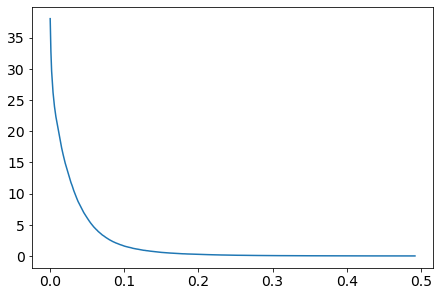

In [17]:
# can combine to form D
beta_post = numpyro_data.posterior.beta
N_post = numpyro_data.posterior.N_delta + numpyro_data.posterior.N_prime

d_post = beta_post/(N_post+2*beta_post)

az.plot_dist(d_post)
print("true d = ", .5/(16+1))

# "complex" version of the model

The code below generates 

In [179]:
# removed torch dependency 3/22/21, 12:22 PM
%run -i 'model_helpers.py'

## ------
## simulate data into pandas DataFrame
## -------
n_participants = 20
n_blocks = 3

# trial_types = trial_types[1:4]
trial_types = list(df.querytype)
n_trial_types = len(trial_types)

trials = trial_types*n_blocks
blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))

all_thetas = make_thetas(n_participants)
all_responses = create_response_vec_complex(trials, all_thetas, beta = 1, N_base = 15, N_prime = 3, k =20) # updated for Normal errors, .05 is a pretty large amount of noise

all_trials = trials*n_participants
all_blocks = blocks*n_participants

sim_data = pd.DataFrame(
    data = {
        "ID": all_participants,
        "querytype": all_trials, 
        "block": all_blocks,
        "response": all_responses
    }
)  >>  mutate(response = X.response.replace({0:.01, 1:.99}))

# num_vecs, denom_vecs defined in model_helpers.py

trial_list = list(sim_data.querytype)
X_num = jnp.stack([num_vecs[trial] for trial in trial_list])
X_denom = jnp.stack([denom_vecs[trial] for trial in trial_list])

X_data = {
    "trial": trial_list,
    "X_num": X_num,
    "X_denom": X_denom,
    "subj": list(sim_data.ID),
    "block": list(sim_data.block)
}

y_data = jnp.array(sim_data.response.to_numpy())

sim_data.head()
# sim_data >> filter_by(X.response>1)

,ID,querytype,block,response
0,0,A,0,0.811066
1,0,AandB,0,0.451377
2,0,AandnotB,0,0.301592
3,0,AgB,0,0.944855
4,0,AgnotB,0,0.790001


In [258]:
def bayesian_sampler_complex(data, y=None):

    n_Ps = len(np.unique(data["subj"]))
    trial = data["trial"]
    subj = data["subj"]
    conjdisj = jnp.array([is_conjdisj(i) for i in trial])
    not_conjdisj = jnp.array([abs(1-is_conjdisj(i)) for i in trial])

    # population level parameters/priors
    beta = numpyro.sample("beta", dist.HalfCauchy(.5))
    N_delta = numpyro.sample("N_delta", dist.HalfCauchy(5))
    N_prime = numpyro.sample("N_prime", dist.HalfCauchy(5))
#     N_delta = numpyro.sample("N_delta", dist.HalfNormal(50))
#     N_prime = numpyro.sample("N_prime", dist.HalfNormal(50))
    k = numpyro.sample("k", dist.TruncatedNormal(0, 45, 15))
#     sigma = numpyro.sample("sigma", dist.HalfNormal(.1))
    
    N = N_prime + N_delta*not_conjdisj

    # need a theta per person/querytype 
    with numpyro.plate("subj", n_Ps):
        theta = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
        
    numerator = jnp.sum(theta[subj,:]*data["X_num"], axis=-1) # the indexing is the key!!!!!
    denom = jnp.sum(theta[subj,:]*data["X_denom"], axis=-1)
    pi = jnp.divide(numerator, denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)

    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_bs, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [251]:
from jax import random
from numpyro.infer import MCMC, NUTS

nuts_kernel = NUTS(bayesian_sampler_complex)
mcmc = MCMC(nuts_kernel, num_warmup=250, num_samples=1_000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, X_data, y_data)

sample: 100%|██████████| 1250/1250 [00:07<00:00, 170.02it/s, 63 steps of size 5.26e-02. acc. prob=0.96] 


In [252]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    N_delta      9.23      7.42      6.98      1.01     18.49    230.38      1.00
    N_prime      2.91      2.31      2.29      0.29      5.60    336.16      1.00
       beta      0.88      0.71      0.68      0.10      1.67    341.03      1.00
      sigma      0.09      0.00      0.09      0.09      0.10   2004.11      1.00
 theta[0,0]      0.39      0.03      0.39      0.35      0.43    957.03      1.00
 theta[0,1]      0.44      0.03      0.44      0.40      0.48    985.00      1.00
 theta[0,2]      0.01      0.01      0.01      0.00      0.03    408.12      1.00
 theta[0,3]      0.16      0.02      0.16      0.12      0.20    793.86      1.00
 theta[1,0]      0.44      0.03      0.44      0.39      0.48   1699.90      1.00
 theta[1,1]      0.01      0.01      0.01      0.00      0.03    603.28      1.00
 theta[1,2]      0.21      0.02      0.21      0.17      0.24   1120.55      1.01
 theta[1,3]    

## Prior predictive checks

Time to do some prior predictive checks. This will be a chance to work with `arviz` and other plotting tools a bit.

What I want to do:

* simulate from prior
* generate prior predictive
* grab one "participant" and plot some of their predicted responses
    * especially look at conjunction/disjunction fallacies: "A" vs "A and B"

In [259]:
from numpyro.infer import Predictive

prior = Predictive(bayesian_sampler_complex, num_samples=500)

rng_key1 = random.PRNGKey(1)
prior_predictive = prior(rng_key1, X_data)["yhat"]


<AxesSubplot:>

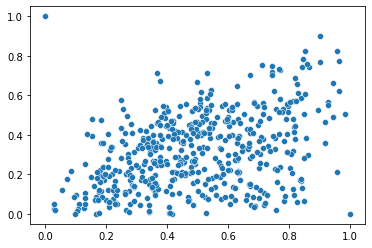

In [260]:
sns.scatterplot(y = prior_predictive[:,1], x = prior_predictive[:,0])

Here's a plot of predictive draws of A and AandB for one simulated participant. Definitely some features that seem right, lots of conjunction fallacy going on in this simulated plot. the dot in the far left corner is weird, that must be coming from a very low value of $k$ 

## simulated drawing samples

I think a better way to model all of this is as a real trial-level process of sampling. The code below implements this. It samples a bit poorly (low effective samples) but it does sample, Rhats look ok.

So


In [20]:
%run -i 'model_helpers.py'

## ------
## simulate data into pandas DataFrame
## -------
n_participants = 2
n_blocks = 5

# trial_types = trial_types[1:4]
trial_types = list(df.querytype)
n_trial_types = len(trial_types)

trials = trial_types*n_blocks
blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))

all_thetas = make_thetas(n_participants)
all_responses = create_response_vec2(trials, all_thetas, beta = 1, N=10, sigma=.05) # updated for Normal errors, .05 is a pretty large amount of noise

all_trials = trials*n_participants
all_blocks = blocks*n_participants

sim_data = pd.DataFrame(
    data = {
        "ID": all_participants,
        "querytype": all_trials, 
        "block": all_blocks,
        "response": all_responses
    }
)  >>  mutate(response = X.response.replace({0:.01, 1:.99}))

# num_vecs, denom_vecs defined in model_helpers.py

trial_list = list(sim_data.querytype)
X_num = jnp.stack([num_vecs[trial] for trial in trial_list])
X_denom = jnp.stack([denom_vecs[trial] for trial in trial_list])

X_data = {
    "trial": trial_list,
    "X_num": X_num,
    "X_denom": X_denom,
    "subj": jnp.array(list(sim_data.ID)),
    "block": jnp.array(list(sim_data.block))
}

y_data = jnp.array(sim_data.response.to_numpy())

sim_data.head()

,ID,querytype,block,response
0,0,A,0,0.438567
1,0,AandB,0,0.050805
2,0,AandnotB,0,0.425559
3,0,AgB,0,0.084409
4,0,AgnotB,0,0.445980


In [21]:
def bayesian_sampler2(data, y=None):

    n_Ps = len(np.unique(data["subj"]))
    trial = data["trial"]
    subj = data["subj"]

    # population level parameters/priors
    beta = numpyro.sample("beta", dist.HalfCauchy(1))

    sigma = numpyro.sample("sigma", dist.HalfNormal(.05)) # response noise parameter
#     sigma = .02

    # need a theta per person/querytype 
    with numpyro.plate("subj", n_Ps):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
        Ns = numpyro.sample("N", dist.HalfCauchy(5)) # gotta add pooling here

    N = Ns[subj]    
    theta = thetas[subj,:]
    
    numerator = jnp.sum(theta*data["X_num"], axis=-1)
    denom = jnp.sum(theta*data["X_denom"], axis=-1)
    pi_l = jnp.divide(numerator, denom)
    
    with numpyro.plate("data", len(trial)):
        pi = numpyro.sample("pi", dist.Beta(N*pi_l, N*(1-pi_l))) # continuous approx to binomial()
        p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
        yhat = numpyro.sample("yhat", dist.Normal(p_bs, sigma), obs=y)
        
    
    return yhat

In [22]:
from jax import random
from numpyro.infer import MCMC, NUTS

nuts_kernel = NUTS(bayesian_sampler2)
mcmc = MCMC(nuts_kernel, num_warmup=1_000, num_samples=1_000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, X_data, y_data)

sample: 100%|██████████| 2000/2000 [00:10<00:00, 190.70it/s, 127 steps of size 4.69e-02. acc. prob=0.94]


In [23]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      N[0]     14.04      3.28     13.64      8.72     18.70    129.22      1.04
      N[1]      9.85      1.96      9.65      6.94     13.19    113.94      1.00
      beta      0.80      0.16      0.79      0.53      1.02    139.15      1.00
     pi[0]      0.43      0.04      0.42      0.35      0.49   1157.28      1.00
     pi[1]      0.01      0.01      0.00      0.00      0.03    652.76      1.00
     pi[2]      0.41      0.04      0.41      0.34      0.48   1086.37      1.00
     pi[3]      0.04      0.03      0.03      0.00      0.08    359.25      1.02
     pi[4]      0.44      0.05      0.44      0.37      0.52   1281.78      1.00
     pi[5]      0.78      0.05      0.78      0.70      0.85    708.88      1.00
     pi[6]      0.65      0.05      0.65      0.57      0.72   1071.67      1.00
     pi[7]      0.27      0.04      0.27      0.20      0.34    968.97      1.00
     pi[8]      0.04      0

In [400]:
from numpyro.infer import Predictive

prior = Predictive(bayesian_sampler2, num_samples=500)

rng_key1 = random.PRNGKey(1)
prior_predictive = prior(rng_key1, X_data)["yhat"]


<AxesSubplot:>

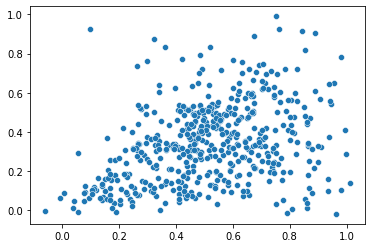

In [401]:
sns.scatterplot(y = prior_predictive[:,1], x = prior_predictive[:,0])